## Train

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Define the MedicalImageDataset class
class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_dir = self.image_dir.replace('imgs', 'masks')
        mask_file=self.images[idx].split('.')[0]+'_mask.png'
        mask_path = os.path.join(mask_dir, mask_file)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define the transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

In [3]:
# Create dataset and dataloaders
image_dataset = MedicalImageDataset('/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/train/imgs', transform=transform)

# Calculate lengths for the splits
train_size = int(0.95 * len(image_dataset))
val_size = len(image_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(image_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [4]:
# Atrous Convolution class
class Atrous_Convolution(nn.Module):
    def __init__(self, input_channels, kernel_size, pad, dilation_rate, output_channels=256):
        super(Atrous_Convolution, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size, padding=pad, dilation=dilation_rate, bias=False)
        self.batchnorm = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

# ASPP Module
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.conv_1x1 = Atrous_Convolution(in_channels, 1, 0, 1, out_channels)
        self.conv_6x6 = Atrous_Convolution(in_channels, 3, 6, 6, out_channels)
        self.conv_12x12 = Atrous_Convolution(in_channels, 3, 12, 12, out_channels)
        self.conv_18x18 = Atrous_Convolution(in_channels, 3, 18, 18, out_channels)
        self.image_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.final_conv = Atrous_Convolution(out_channels * 5, 1, 0, 1, out_channels)

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_6x6 = self.conv_6x6(x)
        x_12x12 = self.conv_12x12(x)
        x_18x18 = self.conv_18x18(x)
        img_pool_opt = self.image_pool(x)
        img_pool_opt = F.interpolate(img_pool_opt, size=x_18x18.size()[2:], mode='bilinear', align_corners=True)
        concat = torch.cat((x_1x1, x_6x6, x_12x12, x_18x18, img_pool_opt), dim=1)
        x_final_conv = self.final_conv(concat)
        return x_final_conv

# ResNet-50 Backbone
class ResNet_50(nn.Module):
    def __init__(self, output_layer=None):
        super(ResNet_50, self).__init__()
        self.pretrained = models.resnet50(pretrained=True)
        self.output_layer = output_layer
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1, len(self.layers)-self.layer_count):
            self.dummy_var = self.pretrained._modules.pop(self.layers[-i])
        self.net = nn.Sequential(self.pretrained._modules)
        self.pretrained = None

    def forward(self, x):
        x = self.net(x)
        return x

# DeepLabV3+ Model
class Deeplabv3Plus(nn.Module):
    def __init__(self, num_classes):
        super(Deeplabv3Plus, self).__init__()
        self.backbone = ResNet_50(output_layer='layer3')
        self.low_level_features = ResNet_50(output_layer='layer1')
        self.assp = ASPP(in_channels=1024, out_channels=256)
        self.conv1x1 = Atrous_Convolution(256, 1, 0, 1, 48)
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(304, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):
        x_backbone = self.backbone(x)
        x_low_level = self.low_level_features(x)
        x_assp = self.assp(x_backbone)
        x_assp_upsampled = F.interpolate(x_assp, scale_factor=4, mode='bilinear', align_corners=True)
        x_conv1x1 = self.conv1x1(x_low_level)
        x_cat = torch.cat([x_conv1x1, x_assp_upsampled], dim=1)
        x_3x3 = self.conv_3x3(x_cat)
        x_3x3_upscaled = F.interpolate(x_3x3, scale_factor=4, mode='bilinear', align_corners=True)
        x_out = self.classifier(x_3x3_upscaled)
        return x_out

In [5]:
# Initialize the model
model = Deeplabv3Plus(num_classes=1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

/media/rohit/mirlproject2/fetal head circumference/head/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/rohit/mirlproject2/fetal head circumference/head/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Define Dice Loss
def dice_loss(inputs, targets, smooth=1):
    inputs = torch.sigmoid(inputs).view(-1)
    targets = targets.view(-1)
    intersection = (inputs * targets).sum()
    dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
    return 1 - dice

In [7]:

# Define optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 100

# Define EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} ---------------> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=10, verbose=True, path='/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/deeplabv3+_custom_best_model.pth')

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images, masks in train_loader_tqdm:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = dice_loss(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        train_loader_tqdm.set_postfix({"Train Loss": running_train_loss / (train_loader_tqdm.n + 1)})

    avg_train_loss = running_train_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}')

    model.eval()
    running_val_loss = 0.0
    val_loader_tqdm = tqdm(val_loader, desc=f"Validation {epoch+1}/{num_epochs}", unit="batch")

    with torch.no_grad():
        for images, masks in val_loader_tqdm:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            val_loss = dice_loss(outputs, masks)

            running_val_loss += val_loss.item()
            val_loader_tqdm.set_postfix({"Val Loss": running_val_loss / (val_loader_tqdm.n + 1)})

    avg_val_loss = running_val_loss / len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')

    scheduler.step(avg_val_loss)

    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break




Epoch 1/100: 100%|██████████| 71/71 [00:32<00:00,  2.16batch/s, Train Loss=0.584]


Epoch 1, Training Loss: 0.5836


Validation 1/100: 100%|██████████| 4/4 [00:01<00:00,  3.84batch/s, Val Loss=0.616]


Epoch 1, Validation Loss: 0.6158
Validation loss decreased (inf ---------------> 0.615831).  Saving model ...


Epoch 2/100: 100%|██████████| 71/71 [00:23<00:00,  3.00batch/s, Train Loss=0.399]


Epoch 2, Training Loss: 0.3988


Validation 2/100: 100%|██████████| 4/4 [00:00<00:00,  6.63batch/s, Val Loss=0.379]


Epoch 2, Validation Loss: 0.3788
Validation loss decreased (0.615831 ---------------> 0.378816).  Saving model ...


Epoch 3/100: 100%|██████████| 71/71 [00:22<00:00,  3.09batch/s, Train Loss=0.312]


Epoch 3, Training Loss: 0.3122


Validation 3/100: 100%|██████████| 4/4 [00:00<00:00,  6.14batch/s, Val Loss=0.305]


Epoch 3, Validation Loss: 0.3045
Validation loss decreased (0.378816 ---------------> 0.304516).  Saving model ...


Epoch 4/100: 100%|██████████| 71/71 [00:22<00:00,  3.18batch/s, Train Loss=0.224]


Epoch 4, Training Loss: 0.2238


Validation 4/100: 100%|██████████| 4/4 [00:00<00:00,  6.51batch/s, Val Loss=0.28] 


Epoch 4, Validation Loss: 0.2799
Validation loss decreased (0.304516 ---------------> 0.279927).  Saving model ...


Epoch 5/100: 100%|██████████| 71/71 [00:22<00:00,  3.13batch/s, Train Loss=0.168]


Epoch 5, Training Loss: 0.1679


Validation 5/100: 100%|██████████| 4/4 [00:00<00:00,  6.57batch/s, Val Loss=0.299]


Epoch 5, Validation Loss: 0.2988
EarlyStopping counter: 1 out of 10


Epoch 6/100: 100%|██████████| 71/71 [00:22<00:00,  3.21batch/s, Train Loss=0.146]


Epoch 6, Training Loss: 0.1461


Validation 6/100: 100%|██████████| 4/4 [00:00<00:00,  6.51batch/s, Val Loss=0.235]


Epoch 6, Validation Loss: 0.2355
Validation loss decreased (0.279927 ---------------> 0.235459).  Saving model ...


Epoch 7/100: 100%|██████████| 71/71 [00:22<00:00,  3.12batch/s, Train Loss=0.126] 


Epoch 7, Training Loss: 0.1257


Validation 7/100: 100%|██████████| 4/4 [00:00<00:00,  6.44batch/s, Val Loss=0.234]


Epoch 7, Validation Loss: 0.2343
Validation loss decreased (0.235459 ---------------> 0.234341).  Saving model ...


Epoch 8/100: 100%|██████████| 71/71 [00:22<00:00,  3.13batch/s, Train Loss=0.105]


Epoch 8, Training Loss: 0.1049


Validation 8/100: 100%|██████████| 4/4 [00:00<00:00,  6.50batch/s, Val Loss=0.232]


Epoch 8, Validation Loss: 0.2325
Validation loss decreased (0.234341 ---------------> 0.232479).  Saving model ...


Epoch 9/100: 100%|██████████| 71/71 [00:23<00:00,  3.02batch/s, Train Loss=0.0863]


Epoch 9, Training Loss: 0.0863


Validation 9/100: 100%|██████████| 4/4 [00:00<00:00,  6.50batch/s, Val Loss=0.221]


Epoch 9, Validation Loss: 0.2211
Validation loss decreased (0.232479 ---------------> 0.221093).  Saving model ...


Epoch 10/100: 100%|██████████| 71/71 [00:25<00:00,  2.81batch/s, Train Loss=0.076] 


Epoch 10, Training Loss: 0.0760


Validation 10/100: 100%|██████████| 4/4 [00:00<00:00,  6.55batch/s, Val Loss=0.262]


Epoch 10, Validation Loss: 0.2616
EarlyStopping counter: 1 out of 10


Epoch 11/100: 100%|██████████| 71/71 [00:23<00:00,  3.00batch/s, Train Loss=0.0662]


Epoch 11, Training Loss: 0.0662


Validation 11/100: 100%|██████████| 4/4 [00:00<00:00,  6.61batch/s, Val Loss=0.221]


Epoch 11, Validation Loss: 0.2213
EarlyStopping counter: 2 out of 10


Epoch 12/100: 100%|██████████| 71/71 [00:23<00:00,  3.02batch/s, Train Loss=0.0575]


Epoch 12, Training Loss: 0.0575


Validation 12/100: 100%|██████████| 4/4 [00:00<00:00,  6.30batch/s, Val Loss=0.234]


Epoch 12, Validation Loss: 0.2340
EarlyStopping counter: 3 out of 10


Epoch 13/100: 100%|██████████| 71/71 [00:22<00:00,  3.14batch/s, Train Loss=0.0549]


Epoch 13, Training Loss: 0.0549


Validation 13/100: 100%|██████████| 4/4 [00:00<00:00,  6.30batch/s, Val Loss=0.211]


Epoch 13, Validation Loss: 0.2113
Validation loss decreased (0.221093 ---------------> 0.211328).  Saving model ...


Epoch 14/100: 100%|██████████| 71/71 [00:23<00:00,  3.08batch/s, Train Loss=0.0632]


Epoch 14, Training Loss: 0.0632


Validation 14/100: 100%|██████████| 4/4 [00:00<00:00,  6.72batch/s, Val Loss=0.255]


Epoch 14, Validation Loss: 0.2553
EarlyStopping counter: 1 out of 10


Epoch 15/100: 100%|██████████| 71/71 [00:23<00:00,  3.08batch/s, Train Loss=0.0627]


Epoch 15, Training Loss: 0.0627


Validation 15/100: 100%|██████████| 4/4 [00:00<00:00,  6.51batch/s, Val Loss=0.286]


Epoch 15, Validation Loss: 0.2864
EarlyStopping counter: 2 out of 10


Epoch 16/100: 100%|██████████| 71/71 [00:23<00:00,  3.04batch/s, Train Loss=0.0574]


Epoch 16, Training Loss: 0.0574


Validation 16/100: 100%|██████████| 4/4 [00:00<00:00,  6.27batch/s, Val Loss=0.212]


Epoch 16, Validation Loss: 0.2118
EarlyStopping counter: 3 out of 10


Epoch 17/100: 100%|██████████| 71/71 [00:23<00:00,  3.08batch/s, Train Loss=0.0663]


Epoch 17, Training Loss: 0.0663


Validation 17/100: 100%|██████████| 4/4 [00:00<00:00,  6.43batch/s, Val Loss=0.325]


Epoch 17, Validation Loss: 0.3252
EarlyStopping counter: 4 out of 10


Epoch 18/100: 100%|██████████| 71/71 [00:23<00:00,  3.08batch/s, Train Loss=0.11] 


Epoch 18, Training Loss: 0.1097


Validation 18/100: 100%|██████████| 4/4 [00:00<00:00,  5.99batch/s, Val Loss=0.221]


Epoch 18, Validation Loss: 0.2213
EarlyStopping counter: 5 out of 10


Epoch 19/100: 100%|██████████| 71/71 [00:23<00:00,  3.02batch/s, Train Loss=0.0744]


Epoch 19, Training Loss: 0.0744


Validation 19/100: 100%|██████████| 4/4 [00:00<00:00,  6.53batch/s, Val Loss=0.245]


Epoch 19, Validation Loss: 0.2447
Epoch 00019: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 6 out of 10


Epoch 20/100: 100%|██████████| 71/71 [00:24<00:00,  2.96batch/s, Train Loss=0.0555]


Epoch 20, Training Loss: 0.0555


Validation 20/100: 100%|██████████| 4/4 [00:00<00:00,  6.48batch/s, Val Loss=0.225]


Epoch 20, Validation Loss: 0.2246
EarlyStopping counter: 7 out of 10


Epoch 21/100: 100%|██████████| 71/71 [00:23<00:00,  2.97batch/s, Train Loss=0.0493]


Epoch 21, Training Loss: 0.0493


Validation 21/100: 100%|██████████| 4/4 [00:00<00:00,  6.28batch/s, Val Loss=0.219]


Epoch 21, Validation Loss: 0.2185
EarlyStopping counter: 8 out of 10


Epoch 22/100: 100%|██████████| 71/71 [00:24<00:00,  2.94batch/s, Train Loss=0.0453]


Epoch 22, Training Loss: 0.0453


Validation 22/100: 100%|██████████| 4/4 [00:00<00:00,  5.72batch/s, Val Loss=0.229]


Epoch 22, Validation Loss: 0.2285
EarlyStopping counter: 9 out of 10


Epoch 23/100: 100%|██████████| 71/71 [00:24<00:00,  2.96batch/s, Train Loss=0.0435]


Epoch 23, Training Loss: 0.0435


Validation 23/100: 100%|██████████| 4/4 [00:00<00:00,  6.44batch/s, Val Loss=0.222]

Epoch 23, Validation Loss: 0.2222
EarlyStopping counter: 10 out of 10
Early stopping


## Test

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_dir = self.image_dir.replace('imgs', 'masks')
        mask_file=self.images[idx].split('.')[0]+'_mask.png'
        mask_path = os.path.join(mask_dir, mask_file)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define the transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

test_dataset = MedicalImageDataset('/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/test/imgs', transform=transform)

In [3]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
len(test_loader)

50

In [4]:
# Atrous Convolution class
class Atrous_Convolution(nn.Module):
    def __init__(self, input_channels, kernel_size, pad, dilation_rate, output_channels=256):
        super(Atrous_Convolution, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size, padding=pad, dilation=dilation_rate, bias=False)
        self.batchnorm = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

# ASPP Module
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.conv_1x1 = Atrous_Convolution(in_channels, 1, 0, 1, out_channels)
        self.conv_6x6 = Atrous_Convolution(in_channels, 3, 6, 6, out_channels)
        self.conv_12x12 = Atrous_Convolution(in_channels, 3, 12, 12, out_channels)
        self.conv_18x18 = Atrous_Convolution(in_channels, 3, 18, 18, out_channels)
        self.image_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.final_conv = Atrous_Convolution(out_channels * 5, 1, 0, 1, out_channels)

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_6x6 = self.conv_6x6(x)
        x_12x12 = self.conv_12x12(x)
        x_18x18 = self.conv_18x18(x)
        img_pool_opt = self.image_pool(x)
        img_pool_opt = F.interpolate(img_pool_opt, size=x_18x18.size()[2:], mode='bilinear', align_corners=True)
        concat = torch.cat((x_1x1, x_6x6, x_12x12, x_18x18, img_pool_opt), dim=1)
        x_final_conv = self.final_conv(concat)
        return x_final_conv

# ResNet-50 Backbone
class ResNet_50(nn.Module):
    def __init__(self, output_layer=None):
        super(ResNet_50, self).__init__()
        self.pretrained = models.resnet50(pretrained=True)
        self.output_layer = output_layer
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1, len(self.layers)-self.layer_count):
            self.dummy_var = self.pretrained._modules.pop(self.layers[-i])
        self.net = nn.Sequential(self.pretrained._modules)
        self.pretrained = None

    def forward(self, x):
        x = self.net(x)
        return x

# DeepLabV3+ Model
class Deeplabv3Plus(nn.Module):
    def __init__(self, num_classes):
        super(Deeplabv3Plus, self).__init__()
        self.backbone = ResNet_50(output_layer='layer3')
        self.low_level_features = ResNet_50(output_layer='layer1')
        self.assp = ASPP(in_channels=1024, out_channels=256)
        self.conv1x1 = Atrous_Convolution(256, 1, 0, 1, 48)
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(304, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):
        x_backbone = self.backbone(x)
        x_low_level = self.low_level_features(x)
        x_assp = self.assp(x_backbone)
        x_assp_upsampled = F.interpolate(x_assp, scale_factor=4, mode='bilinear', align_corners=True)
        x_conv1x1 = self.conv1x1(x_low_level)
        x_cat = torch.cat([x_conv1x1, x_assp_upsampled], dim=1)
        x_3x3 = self.conv_3x3(x_cat)
        x_3x3_upscaled = F.interpolate(x_3x3, scale_factor=4, mode='bilinear', align_corners=True)
        x_out = self.classifier(x_3x3_upscaled)
        return x_out

In [5]:
def dice_loss(inputs, targets, smooth=1):
    inputs = torch.sigmoid(inputs).view(-1)
    targets = targets.view(-1)
    intersection = (inputs * targets).sum()
    dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
    return 1 - dice

In [6]:
model = Deeplabv3Plus(num_classes=1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

/media/rohit/mirlproject2/fetal head circumference/head/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/rohit/mirlproject2/fetal head circumference/head/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
modelPath = '/media/rohit/mirlproject2/fetal head circumference/Breast_Ultrasound/weights/deeplabv3+_custom_best_model.pth'
state_dict = torch.load(modelPath)
if "model_weight" in state_dict:
    model.load_state_dict(state_dict["model_weight"], strict=False)
else:
    model.load_state_dict(state_dict, strict=False)

model.to(device)

Deeplabv3Plus(
  (backbone): ResNet_50(
    (pretrained): None
    (dummy_var): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(2048, 512, kernel_size=

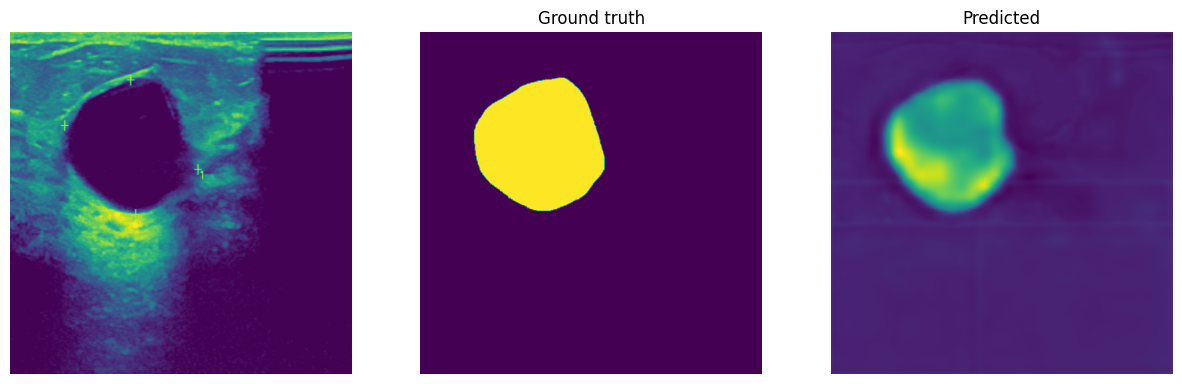

In [8]:
model.eval()
loss_fn = dice_loss
test_loss=[]
dsc_scores = []

for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device)

    outputs = model(images)
    val_loss = dice_loss(outputs, masks)

    dsc = 1 - val_loss
    dsc_scores.append(dsc.item())

    test_loss.append(val_loss.item())

fig,axs=plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(images[0][0].cpu().detach().numpy())
#axs[0].set_title(str(num))
axs[0].axis('off')

axs[1].imshow(masks[0][0].cpu().detach().numpy())
axs[1].set_title("Ground truth")
axs[1].axis('off')

axs[2].imshow(outputs[0][0].cpu().detach().numpy())
axs[2].set_title("Predicted")
axs[2].axis('off')

plt.show()

In [9]:
from statistics import mean

mean(test_loss)

0.21755676746368408

In [10]:
from statistics import mean

mean(dsc_scores)

0.7824432325363159

In [11]:
import pandas as pd

df_dsc = pd.DataFrame(dsc_scores, columns=['DSC'])
df_dsc['Model'] = 'DeepLabV3+'  # Replace with actual model name
df_dsc['Dataset'] = 'Breast Ultrasound'  # Replace with actual dataset name

# Save DataFrame to CSV
df_dsc.to_csv('dsc_scores_DeepLabV3+_Breast Ultrasound.csv', index=False)

: 

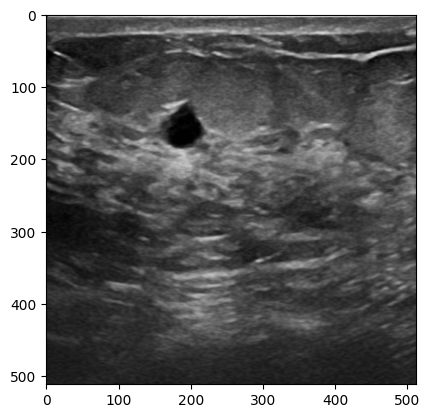

: 

In [11]:
i=0
for img,mask in test_loader:
    i+=1
    if i==8:
        break


images=img[0]
images=images.permute(1,2,0)
plt.imshow(images)

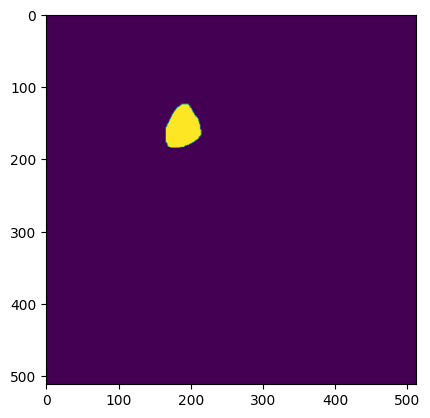

In [ ]:
gt=mask[0]
gt=gt.permute(1,2,0)
plt.imshow(gt)

In [ ]:
mask.shape

torch.Size([1, 1, 512, 512])

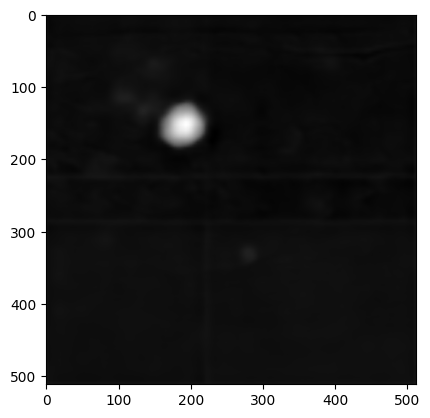

In [ ]:
i=0
for img,mask in test_loader:
    i+=1
    if i==8:
        break

outputs = model(img.to(device))

pred=outputs[0][0].cpu().detach().numpy()
# pred=pred.permute(1,2,0)
plt.imshow(pred,cmap='gray')

0.24017012119293213


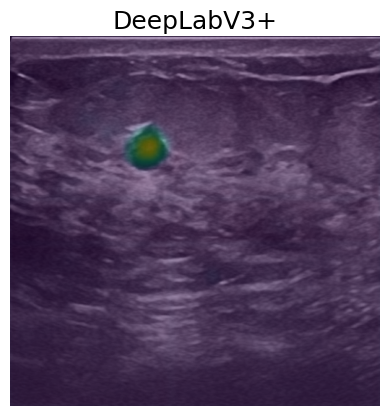

In [ ]:
i=0
for images, masks in test_loader:
    i+=1
    if i==8:
        break
    else:
        continue

images, masks = images.to(device), masks.to(device)

outputs = model(images)
val_loss = loss_fn(outputs, masks)

print(val_loss.item())

img=images[0][0].cpu().detach().numpy()
gt=masks[0][0].cpu().detach().numpy()
pred=outputs[0][0].cpu().detach().numpy()


plt.imshow(img,cmap='gray')
plt.imshow(pred,alpha=0.4)

plt.title('DeepLabV3+', fontsize=18)
plt.axis('off')

plt.show()